### 贝叶斯定理
概率论中最基本的公式有加和定理和乘法定理，后面的各种概率相关的公式实际上都是从这两个公式中推导出的。
$$ sum \  rule \quad p(X) = \sum_Y p(X,Y) $$
$$ product \  rule \quad p(X,Y) = p(Y|X)p(X) $$
在这之上又能推导非常实用的贝叶斯定理，它给出先验、似然和证据的关系，即观测、知识与实际情况的相互影响。
$$ bayes \  rule \quad p(Y|X) = \frac{p(X|Y)p(Y)}{P(X)} $$
其中P(Y)叫先验，即不考虑其他因素时，Y的统计概率。所以在我们除了先验一无所知时，就可以直接根据先验做判决。比如我们在河里捞鱼，农民告诉我们河里的鲑鱼比鲈鱼多，而我们又不知道任何分辨鱼的知识，这时如果我们捞上一条鱼，则我们直接判断它是鲑鱼。这样做能让分类的错误率最小。  
而如果我们知道一些知识，就能做出更理智的决策。公式中的P(X)是证据，P(X|Y)是似然。所谓证据是我们对目标进行观测后，找到的特征(Y具有X属性)。而似然是对某一类的Y，它具有X属性的统计概率。比如河里的鱼，鲑鱼和鲈鱼的比例是7:3.然后我们捞上了一条很光泽的鱼，农民告诉我们鲈鱼很光泽的概率是0.5，鲑鱼很光泽的概率是0.1。因为0.7x0.1<0.3x0.5，我们就能下决策，这条鱼是鲈鱼。  
在决策中，因为同一个样本分类到各个类别时，证据是一样的。因此证据的概率不在决策中发挥作用，它的存在是为了让式子的值小于1，具有概率意义。

### 贝叶斯决策
如果我们能设计一个概率模型，它能很好地逼近每个类别先验下似然的真实分布；那么我们就能在预测时，从模型中得到似然概率，再结合统计的到的先验概率，就能做出优秀的决策。连续特征下，统计学家最喜欢用于做类似的事情的概率密度模型是高斯分布，它的密度函数是
$$ p(x)\ =\ \frac{1}{(2\pi)^{1/2}\vert \Sigma \vert ^{1/2}}exp[-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)] $$

### 高维特征下的贝叶斯决策
上面我们已经演示了如何使用证据来做决策。事实上我们得到的信息不止鱼的光泽这一项，我们还会分析鱼的大小，鱼的鳞片形状，鱼的颜色等等。只要我们能获得贝叶斯公式中的似然，就能下一个让分类错误率最小的决策。但是如果贝叶斯决策论真的那么厉害，我们就不会在今天发展深度学习了。贝叶斯决策相当大的劣势在于，当维度变高后，概率分布会指数级别地变得稀疏，从而我们想精确地计算多特征下的高维先验就不是那么容易。为此，我们提出了一系列的假设，帮助我们在高维特征下使用贝叶斯理论。  
**条件独立性假设**  
当两个事件相互独立，则它们的概率就可以写成$ P(X,Y) = P(X)P(Y) $。从而，似然的联合概率分布就变得容易计算，只需要把每个属性自己的概率计算出来，再求乘积就得到联合概率。如果用这个方法计算似然，就能很大程度上减小分析难度。但是如果真实情形下条件独立性不成立的程度很大，则这个假设很有可能带来不利的影响。  
**离散特征的分布**  
对每个离散特征而言，它的状态空间有限。我们可以计算它的每种状态的统计概率作为似然。   
**连续特征的分布**  
连续特征如果不去特地考察，就很难给出合理的分布假设。统计学中一般用混合的高斯模型去逼近连续的分布，只要混合模型的高斯簇足够多，它就能逼近任何分布。而在实践中，为了计算的方便，我们很多时候就直接用一个一维的高斯分布逼近(只需要计算样本均值和方差)。  
使用上面的方法得到的贝叶斯分类器，被称为朴素贝叶斯分类器(Naive Bayes)

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
import random
import scipy.stats as stats
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
X,y = datasets.load_wine(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

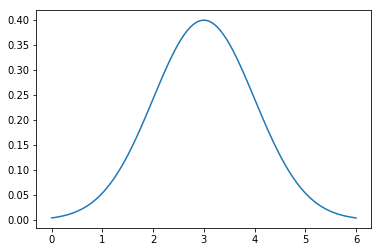

In [3]:
# SCIPY库里可以直接调高斯分布的函数stats.norm.pdf
xx = np.linspace(0,6,100)
plt.plot(xx,stats.norm.pdf(xx,loc=3,scale=1))

In [4]:
# 我们实现简单的NB分类器，这里仅针对连续特征进行
class NBClassifier:
    def __init__(self):
        self.means = []
        self.vars = []
        self.prior = []
        self.classes = 0
        
    def fit(self, X, y):
        n,m = X.shape
        # 对每个类别计算均值方差
        self.classes = y.max()+1
        for i in range(self.classes):
            index = np.where(y==i)
            self.prior.append(len(index)/n)
            X_C = X[index]
            self.means.append(np.mean(X_C,axis = 0))
            self.vars.append(np.var(X_C,axis = 0))
        
    def predict(self, X):
        n,m = X.shape
        probs = np.zeros((self.classes,n))
        # 对每个类别计算后验
        for i in range(self.classes):
            p = self.prior[i] #先验概率
            for j in range(m): #对每个特征
                p *= stats.norm.pdf(X[:,j],loc=self.means[i][j],scale=np.sqrt(self.vars[i][j])) # 高斯分布
            probs[i]=p # 这里算完后的p是一个n长度一维数组，代表所有样本在第i类的后验概率
        ret = np.argmax(probs, axis = 0) #取最大概率的类别作为决策
        return ret

In [5]:
model = NBClassifier()
model.fit(X_train,y_train)
accuracy_score(model.predict(X_test),y_test)

0.9166666666666666

NB算法非常简单，从代码实现上也可以看出来，核心代码不超过10行，但是它的表现却很不错。尤其是当条件独立性假设符合的比较好时，这种正确率和计算速度上的优势就体现得更为明显。它甚至是“数据挖掘10大算法”。

### 贝叶斯网
很多时候，我们希望用贝叶斯定理做更多的事情。如果我们已经从人类的经验中得到了几个事件的依赖性关系，我们就能实现通过乘法定理和加法定理把概率从一些传播到其他事件，实现“多对多”的推理任务。把这种算法结构化，就是贝叶斯网络。我们的NB算法本质上也是贝叶斯网络。  
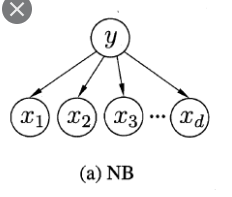
而一般的贝叶斯网络是更为复杂的有向无环图，比如下面的
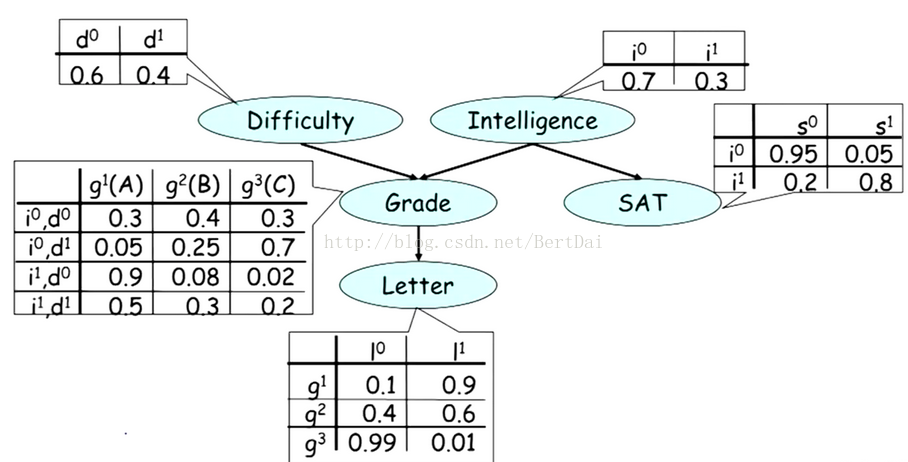
每个贝叶斯网的结点存储的是一张CPT表，代表父节点状态为X时，当前结点状态为Y的概率。这样，当网络中某些事件的状态已知时，就能通过信念链的传播计算出其他结点的状态、或者处于某状态的概率(确信处于某状态即该状态概率为1，其他状态概率为0).

### 推断
虽然从视觉上，我们可以很轻松地把某个概率在图上传播下去，但是实践起来并没有那么简单。因为传播的信息往往不是标量的信息，而是表的信息。
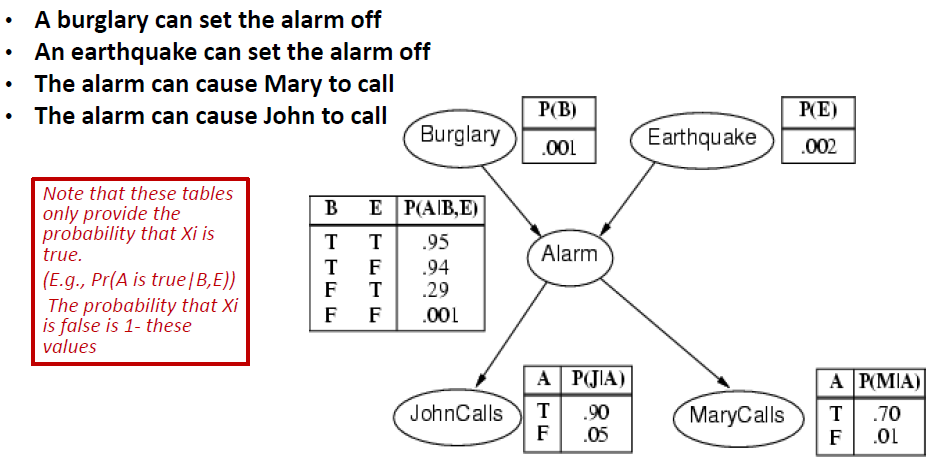
具体到实践上又是怎么样的呢？我们来看一个所有事件都是二值的，离散的贝叶斯网络例子。  
如果我们要求一个条件概率，当mary和john都call时，发生burglary的概率。即P(B|j,m).我们可以先计算给定条件下的条件联合概率，再用全概率公式消去无关变量，计算条件概率。$$ P(B|j,m) = \alpha P(B,j,m) = \alpha \sum_e \sum_a P(B,j,m,E,A) $$其联合概率根据贝叶斯网络写出$$ p(b,j,m) = \alpha \sum_e \sum_a P(b)P(e)P(a|b,e)P(j|a)P(m|a) $$
这种枚举计算概率的算法复杂度是$n2^n$，在小型的贝叶斯网络里可以接受，但是如果变量稍微多一点(10以上)，这个时间开销就很大了。为此我们有更高效的变量消元算法，从上面的式子我们可以看出，算法的每一项虽然是条件概率，但是计算时我们都是把变量的值代入，然后计算(从CPT表中找出一个值)一个概率，再用全概率公式消元。如果我们同时进行消元和概率乘法，需要遍历的状态空间也许并没有那么大。
$$ p(b,j,m) = \alpha P(b)\sum_e P(e) \sum_a P(a|b,e)P(j|a)P(m|a) $$
其实还有更多贝叶斯网推断的方法，比如信念传播。不过我们就不深究怎么实现了，毕竟贝叶斯网不是我们模式识别的重点内容，只需要了解个大概即可。

In [6]:
class Node:
    def __init__(self, varList, cpt):
        '''
        varList给出了所有和当前状态的P相关的变量名
        cpt按照varList的顺序给出了"编码"->"概率"对
        如varList = ['A','B',C']
        cpt['010'] = P('~A,B,~C')
        '''
        self.varList = varList
        self.cpt = cpt
        
        
    def prob(self, variables, code):
        '''
        允许不同于varList的顺序的vars输入
        来查询cpt表。如vars = ['B','C','A']
        code = "010"。则该接口先把010转为001
        再访问cpt表
        '''
        actual_code = ["0" for i in range(len(code))]
        for i in range(len(variables)):
            j = self.varList.index(variables[i])
            actual_code[j] = code[i]
        key = ''.join(['1','2','3'])
        return self.cpt[key]
    
    
class BayesNet:
    def __init__(self):
        self.nodes = []
        self.varList = []
        
    def AddNode(self, node):
        self.nodes.append(node)
        self.varList = list(set(self.varList+node.varList))
        
    def GetCodes(self, restricted_vars):
        '''
        在给出的约束条件下生成所有事件可能性
        restricted_vars: dict {variable name : value}
        '''
        initList = [["-1" for i in range(len(self.varList))]]
        for var,value in restricted_vars.items():
            i = self.varList.index(var)
            initList[0][i] = value
        return self.GetPremu(initList, 0)
        
        
    def GetPremu(self, codeList, front):
        if front>=len(self.varList):
            return codeList
        if codeList[0][front]!="-1":
            return self.GetPremu(codeList, front+1)
        # 复制一份codeList，在front下标处设置0和1
        N = len(codeList)
        for i in range(N):
            codeList[i][front] = "0"
        anotherList = copy.deepcopy(codeList)
        for i in range(N):
            codeList[i][front] = "1"
        return self.GetPremu(codeList+anotherList, front+1)
    
    def Inference(self, evidences, query):
        '''
        在给出的证据下计算query的概率
        evidences: dict {variable name : value}
        '''
        Probs = [0,0]
        for query_code in [0,1]:
            evidences[query] = str(query_code)
            codeList = self.GetCodes(evidences)
            for code in codeList:
                p = 1
                for node in self.nodes:
                    nodeCode = ""
                    for var in node.varList:
                        i = self.varList.index(var)
                        nodeCode += code[i]
                    p *= node.cpt[nodeCode]
                Probs[query_code] += p
        Norm = sum(Probs)
        Probs[0],Probs[1] = Probs[0]/Norm,Probs[1]/Norm
        return Probs

In [7]:
B = Node(["B"], {'0': 0.999, '1': 0.001})
E = Node(["E"], {'0': 0.998, '1': 0.002})
A = Node(["A", "B", "E"], {'111': 0.95, '011': 0.05, '110':0.94,'010':0.06,
'101':0.29,'001':0.71,'100':0.001,'000':0.999})
J = Node(["J", "A"], {'11': 0.9, '01': 0.1, '10': 0.05, '00': 0.95})
M = Node(["M", "A"], {'11': 0.7, '01': 0.3, '10': 0.01, '00': 0.99})

In [8]:
net = BayesNet()
net.AddNode(B)
net.AddNode(E)
net.AddNode(A)
net.AddNode(J)
net.AddNode(M)

In [9]:
print("P(Alarm)",end = ' ')
print(net.Inference({},"A")[1])
print("P(Burglary|John,Mary)",end = ' ')
print(net.Inference({'J':'1','M':'1'},"B")[1])
print("P(Alarm|~John,Mary)",end = ' ')
print(net.Inference({'J':'0','M':'1'},"A")[1])
print("P(Mary|EarthQuake)",end = ' ')
print(net.Inference({'M':'1'},"E")[1])
print("P(John|~EarthQuake,Burglary)",end = ' ')
print(net.Inference({'E':'0','B':'1'},"J")[1])
print("P(EarthQuake|Burglary)",end = ' ')
print(net.Inference({'B':'1'},"E")[1])
print("P(EarthQuake|~Burglary,Alarm)",end = ' ')
print(net.Inference({'B':'0','A':'1'},"E")[1])

P(Alarm) 0.0025164420000000002
P(Burglary|John,Mary) 0.2841718353643929
P(Alarm|~John,Mary) 0.018249738245007474
P(Mary|EarthQuake) 0.03588091528645573
P(John|~EarthQuake,Burglary) 0.8490000000000001
P(EarthQuake|Burglary) 0.002
P(EarthQuake|~Burglary,Alarm) 0.36755386565272496


贝叶斯网在建立好后，能根据事实推断任何事件的后验概率。因为贝叶斯网中的变量可以自由设置依赖条件，它具有着很好的模拟真实情况的能力，而且具有非常优秀的可解释性。但是如果我们不去手动设计网络结构，而是让算法自己学习，这将比想象的要困难得多。